# Prelimenary Comodities Price Prediction Model

*   Ini pakai dataset scrapping dari SP2KP
*   Model masih belum bisa prediksi harga secara mandiri (16/11/2023)



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
# Create a custom month mapping
month_mapping = {
    'January': 'Januari',
    'February': 'Februari',
    'March': 'Maret',
    'April': 'April',
    'May': 'Mei',
    'June': 'Juni',
    'July': 'Juli',
    'August': 'Agustus',
    'September': 'September',
    'October': 'Oktober',
    'November': 'November',
    'December': 'Desember'
}

# Function to convert the month names
def custom_date_parser(x):
    for month, month_abbr in month_mapping.items():
        x = x.replace(month_abbr, month)
    return pd.to_datetime(x, format='%B %d')



In [ ]:
data = pd.read_csv('Beras_Premium.csv', parse_dates=['date'], date_parser=custom_date_parser)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')
price_data = data['price'].values.reshape(-1, 1)
scaler = MinMaxScaler()
price_data = scaler.fit_transform(price_data)


In [ ]:
train_size = int(len(price_data) * 0.80)  # Split 80:20
test_size = len(price_data) - train_size
train_data, test_data = price_data[0:train_size, :], price_data[train_size:len(price_data), :]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=seq_length))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
6/6 [==============================] - 1s 3ms/step - loss: 0.1918
Epoch 2/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0863
Epoch 3/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 4/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 5/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 6/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 7/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 8/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 9/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 10/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 11/50
6/6 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 12/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 13/50
6/6 [==============================] - 0s 4ms/step - loss: 0.

In [ ]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

Train Loss: 0.0005649763625115156
Test Loss: 0.005978243891149759


In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


2/2 [==============================] - 0s 5ms/step


In [ ]:
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

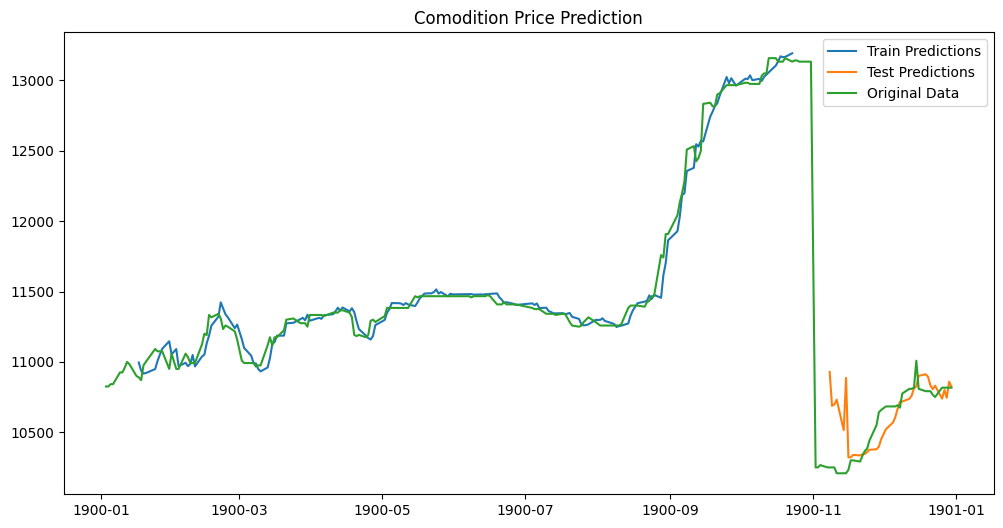

In [ ]:
#Buat plotting
plt.figure(figsize=(12, 6))
plt.plot(data['date'][seq_length:train_size], train_predictions, label="Train Predictions")
plt.plot(data['date'][train_size + seq_length:], test_predictions, label="Test Predictions")
plt.plot(data['date'], scaler.inverse_transform(price_data), label="Original Data")
plt.legend()
plt.title('Comodition Price Prediction')
plt.show()


# BUTUH REVISI, MASIH BELUM BEKERJA BJIR!!!

1/1 [==============================] - 0s 30ms/step


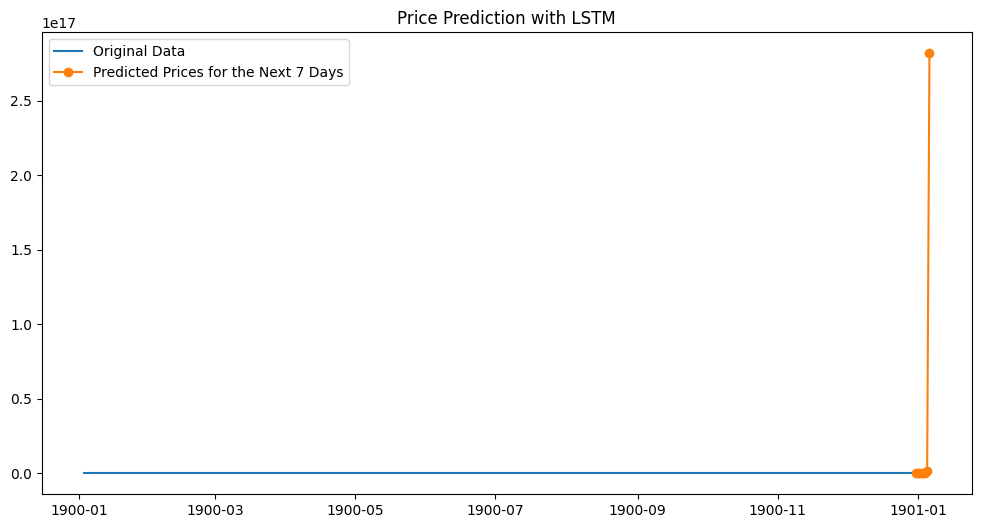

In [ ]:
# Number of days to predict
days_to_predict = 7

# Use the last seq_length days from the training set as the initial input
initial_input = train_data[-seq_length:]

# List to store the predicted prices
predicted_prices = []

# Make predictions for the next 7 days
for i in range(days_to_predict):
    # Reshape the input for prediction
    input_sequence = initial_input[-seq_length:].reshape((1, seq_length, 1))

    # Make the prediction
    predicted_price = model.predict(input_sequence)

    # Inverse transform the prediction to the original scale
    predicted_price = scaler.inverse_transform(predicted_price)

    # Append the predicted price to the list
    predicted_prices.append(predicted_price[0, 0])

    # Update the input sequence for the next iteration
    initial_input = np.append(initial_input, predicted_price, axis=0)

# Generate dates for the next 7 days
last_date = data['date'].iloc[-1]
next_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=days_to_predict)

# Plot the original data and the predicted prices for the next 7 days
plt.figure(figsize=(12, 6))
plt.plot(data['date'], scaler.inverse_transform(price_data), label="Original Data")
plt.plot(next_dates, predicted_prices, label="Predicted Prices for the Next 7 Days", marker='o')
plt.legend()
plt.title('Price Prediction with LSTM')
plt.show()


In [ ]:
model.save("caberawitmerah_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Opsional, buat load model :
model = tf.keras.models.load_model("lstm_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("lstm_model.tflite", "wb") as f:
    f.write(tflite_model)